In [2]:
%matplotlib inline
import numpy as np
from IPython.display import display, clear_output
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, IntSlider, FloatSlider
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib.patches import Rectangle
from PIL import Image
import time
import warnings
from time import sleep
warnings.filterwarnings('ignore')
# %matplotlib notebook

In [2]:
lego = np.array(Image.open('resources/lego.png'), dtype=np.uint8)

## Pixel based Segmentation

### Manual Threshold Segmentation

For the first task, you have to implement a method to distinguish between foreground and background by defining manually a threshold value. In other words, all values under a certain threshold become 0 and everything else to 1. Use matplotlib to plot the source image, the binary mask, and the segmented source image. Your segmented image should be white at the positions where the binary mask is 0. 

![](resources/manual-threshold.png)

**Hints**
- You can easily create binary masks with conditions in numpy, for instance: `mask = A < threshold`
- The resulting mask can be used for indexing, for instance: `A[mask]`
- Don't forget to copy the original numpy array (image), otherwise it could happen that you change it

#### Solution

In [3]:
def mask_image(threshold, gray, title=""):
    mask = gray > threshold
    masked_gray = gray.copy()
    masked_gray[mask] = 255
    
    fig = plt.figure(figsize=(6,6))
    plt.suptitle(title)
    plt.subplot(221)
    plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
    plt.subplot(222)
    plt.imshow(mask)
    plt.subplot(212)
    plt.imshow(masked_gray, cmap='gray', vmin=0, vmax=255)
    plt.tight_layout()
    plt.show()

#### Visualization

In [4]:
@interact(threshold=IntSlider(min=0, max=255, value=0, step=1, continuous_update=False))
def run(threshold):
    mask_image(threshold, lego, 'Manual Threshold of {}'.format(threshold))

interactive(children=(IntSlider(value=0, continuous_update=False, description='threshold', max=255), Output())…

### Threshold Segmentation using Otu's Method

Finding the right threshold is difficult and should not be a trial and error procedure. For this task, you have to implement Otsu's method to find an optimal threshold value T. 

1. You need a normalized histogram for the image you want to segment and based on this values you have to calculate the cumulative histogram.  
2. Determine the mean of the entire image
3. Calculate the cumulative mean value for all intensities
4. Iterate over the K intensities from 1 to 254, exclude 0 and 255
    1. determine the cumulative propability of k
    2. determine the cumulative mean of k
    3. calcualte the between-class variance $\sigma_{B}^2$ of k
    4. set T to k if $max(\sigma_{B}^2)$
5. return threshold T

![](resources/otso-threshold.png)

#### Solution

In [5]:
def threshold_by_otsu(gray):
    hist,_ = np.histogram(gray, 256)
    hist = hist / hist.sum()
    chist = np.cumsum(hist)

    pixel_intensity_probs = (hist * np.arange(0, 256))
    cmean = np.cumsum(pixel_intensity_probs)
    mean = gray.mean()
    print(gray.mean(), mean)
    
    sigmas = np.zeros(254)    
    for k in range(1, 255):
        numerator = (mean * chist[k] - cmean[k])**2
        denominator = chist[k] * (1 - chist[k])
        sigma = numerator / denominator    
        sigmas[k - 1] = sigma
        
    return np.argmax(sigmas) + 1 

#### Visualization

207.2501678466797 207.2501678466797


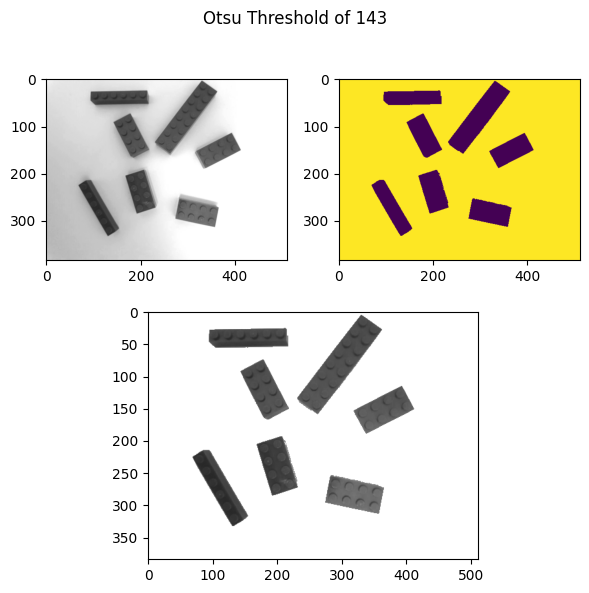

In [6]:
threshold = threshold_by_otsu(lego)
mask_image(threshold, lego, 'Otsu Threshold of {}'.format(threshold))

## Template Matching

### Normalized Cross-Correlation

The idea of template matching is to find a specific template/patch in a reference image. For this task, you have to implement a template matching algorithm based on the *normalized cross-correlation*.
Given is the reference image `coins` and the template `template` with the dimensions 50x50 pixels.

**Steps:**
1. create a padded (add 50 px to width and 50 px to height) copy of coins (np.pad) 
2. iterate over the image
3. extract a 50x50 patch from the reference image
4. calculate the normalized cross correlation of the template and the patch at point P
5. save point P where the normalized cross correlation is the maximum
6. plot the results, draw a rectangle at point P with the shape of the template

You can draw a rectangle using matplotlib:
```python
ax = plt.subplot(221)
ax.add_patch(Rectangle((start_x, start_y), width, height,linewidth=1, edgecolor='r',facecolor='none'))
plt.imshow(...)
```


![](resources/template-matching.png)

In [7]:
coins = np.array(Image.open('resources/coins.jpg').convert('L'), dtype=np.uint8)
template = coins[360:410,400:450]

#### Solution

In [8]:
def find_template(image, template):
    image_padded = np.pad(image, ((0, 50), (0, 50)), mode='reflect')
    correlation = np.zeros(image.shape)
    max_cor = -1
    match_pos = None

    for y in range(coins.shape[0]):
        for x in range(coins.shape[1]):
            patch = image_padded[y:y+template.shape[0], x:x+template.shape[1]].astype(np.float32)
            correlation[y,x] = (patch * template).sum() / (np.sqrt((patch**2).sum()) * np.sqrt(template**2).sum())
            if correlation[y,x] > max_cor:
                match_pos = (y,x)
                max_cor = correlation[y,x]
                
    return correlation, match_pos

#### Visualization

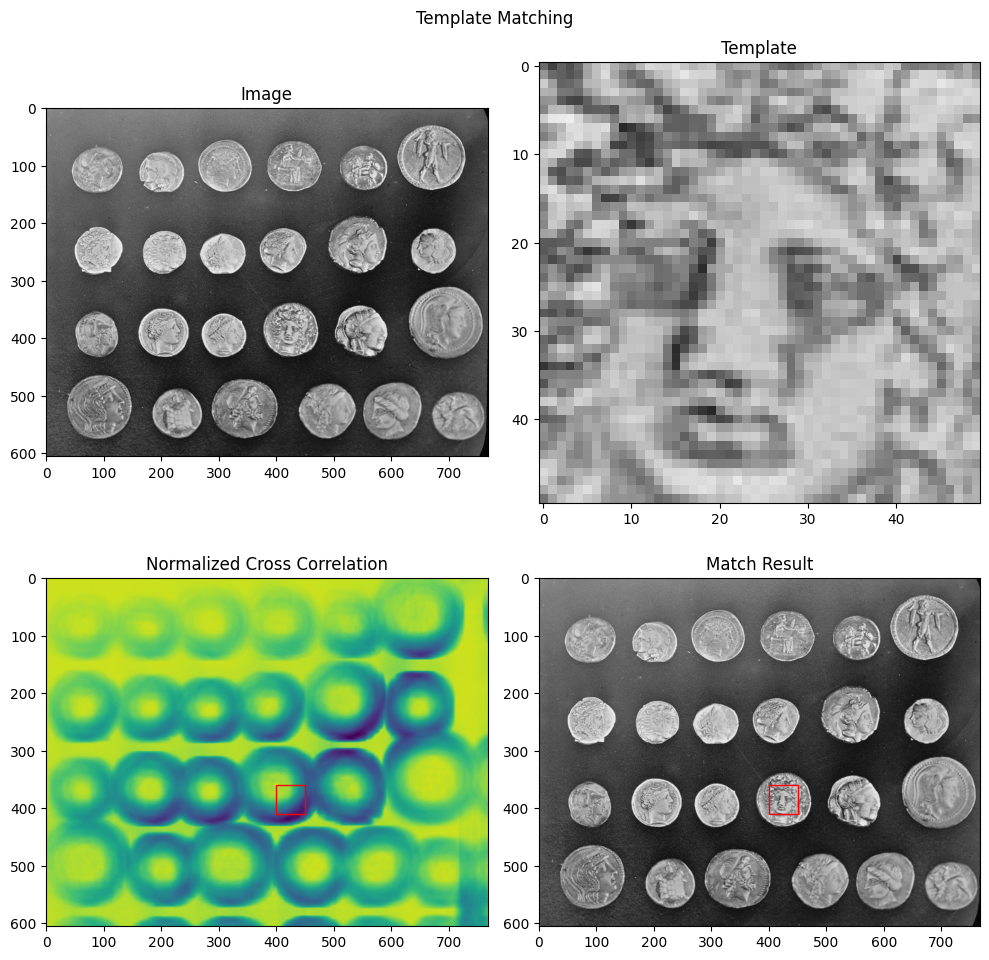

In [9]:
correlation, match_pos = find_template(coins, template)

fig = plt.figure(figsize=(10,10))
plt.suptitle("Template Matching")
plt.subplot(221)
plt.title('Image')
plt.imshow(coins, cmap='gray', vmin=0, vmax=255)
plt.subplot(222)
plt.title('Template')
plt.imshow(template, cmap='gray', vmin=0, vmax=255)
ax3 = plt.subplot(223)
plt.title('Normalized Cross Correlation')
ax3.add_patch(Rectangle((match_pos[1], match_pos[0]), template.shape[1], template.shape[0],linewidth=1, edgecolor='r',facecolor='none'))
plt.imshow(correlation)
ax4 = plt.subplot(224)
plt.title('Match Result')
plt.imshow(coins, cmap='gray')
ax4.add_patch(Rectangle((match_pos[1], match_pos[0]), template.shape[1], template.shape[0],linewidth=1, edgecolor='r',facecolor='none'))
plt.tight_layout()
plt.show()

## Edge based Segmentation

### Canny Edge Operator

In this task you have can try to implement the Canny edge operator.

In [3]:
coins = np.array(Image.open('resources/coins.jpg').convert('L'), dtype=np.uint8)

#### Solution

In [4]:
def convolve(image, kernel):    
    kx_half = kernel.shape[1] // 2
    ky_half = kernel.shape[0] // 2
    
    pad_image = np.pad(image,((ky_half,ky_half),(kx_half,kx_half)), mode='reflect')        
    convolved_image = np.zeros(image.shape)

    for y in range(0, image.shape[0]):
        for x in range(0, image.shape[1]):                           
            mat = pad_image[y:y + kernel.shape[1], x: x + kernel.shape[0]]
            Y = np.multiply(mat, kernel).sum()
            #Y = max(0, min(255, Y)) 
            convolved_image[y,x] = Y
            
    return convolved_image

def build_2d_gauss(sigma, kernel_width):
    #kernel_width = sigma * 2 if (sigma * 2) & 1 != 0 else sigma * 2 + 1
    sigma = 2.0 * sigma*sigma    
    half = kernel_width // 2
    out = np.zeros((kernel_width, kernel_width))
    for y in range(-half, half + 1):
        for x in range(-half, half + 1):
            n = (x**2 + y**2)            
            out[y + half,x + half] = np.exp(-(n/sigma))
    return out / np.sum(out)

In [5]:
coins_filtered = convolve(coins, build_2d_gauss(5.0, 5))
g_y = convolve(coins_filtered,np.array([[-1, -2, -1],[0,0,0],[1,2,1]]))
g_x = convolve(coins_filtered,np.array([[-1, 0, 1],[-2,0,2],[-1,0,1]]))

In [6]:
mag = np.sqrt(g_x**2 + g_y**2)
angle = (np.arctan2(g_y, g_x) * 180) / np.pi

directions = (45.0 * np.floor(angle / 45.0 + 0.5)) / 45.0
directions[directions == -1] = 3
directions = np.abs(directions)
directions[directions == 4] = 1
directions = directions.astype(np.uint8)

s = np.ones_like(mag) * 1
hsv = np.stack([angle / 360, s, s], axis=-1)

filter_size = 3
filter_half = filter_size // 2

mag_pad = np.pad(mag,((filter_half,filter_half),(filter_half,filter_half)), mode='constant')     
directions_pad = np.pad(directions,((filter_half,filter_half),(filter_half,filter_half)), mode='constant')     

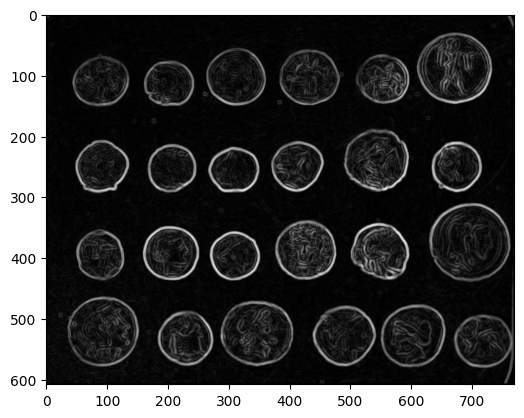

In [7]:
plt.imshow(mag_pad, cmap='gray')

In [8]:
nms_mag = mag.copy()

for y in range(mag.shape[0]):
    for x in range(mag.shape[1]):
        patch = mag_pad[y:y + filter_size, x: x + filter_size]
        direction = directions[y,x]
        if direction == 0:
            l = patch[1,0]
            r = patch[1,2]
        elif direction == 1:
            l = patch[0,0]
            r = patch[2,2]            
        elif direction == 2:
            l = patch[0,1]
            r = patch[2,1]
        elif direction == 3:
            l = patch[0,2]
            r = patch[2,0]                    
        
        if (mag[y,x] < l or mag[y,x] < r):
            nms_mag[y,x] = 0
        

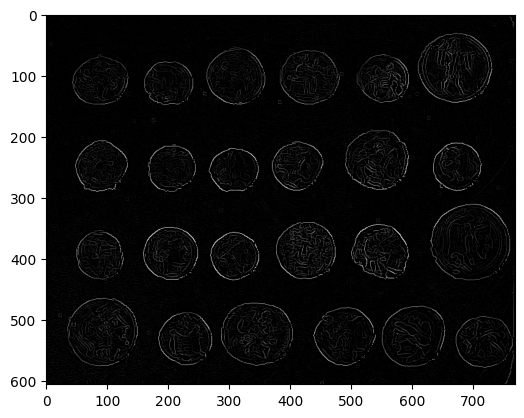

In [9]:
plt.imshow(nms_mag, cmap='gray')

In [10]:
def double_filter(nms_mag, t_min, t_max):
    t_min = int(t_min / 100 * 1024 )
    t_max = int(t_max / 100 * 1024)
    
    print(t_max)
    
    t_max_i = nms_mag.copy()
    t_min_i = nms_mag.copy()
    t_min_i[t_min_i < t_min] = 0
    t_min_i[t_min_i >= t_min] = 1
    t_max_i[t_max_i < t_max] = 0
    t_max_i[t_max_i >= t_max] = 1
    
    print(t_max_i.sum())

    t_delta = t_min_i - t_max_i
    
    t_max_pad = np.pad(t_max_i,((1,1),(1,1)), mode='constant')     
    
    con = np.zeros_like(t_max_i)
    for y in range(t_delta.shape[0]):
        for x in range(t_delta.shape[1]):
            if t_delta[y,x] == 0: 
                continue
                
            patch = t_max_pad[y:y + filter_size, x: x + filter_size]            
            patch[1, 1] = 0
            if patch.sum() == 0:
                con[y,x] = 1
            
            
    return np.clip(t_max_i + con, 0, 1) * 255

#### Visualization 

interactive(children=(FloatSlider(value=2.5, continuous_update=False, description='t_min', step=0.5), FloatSli…

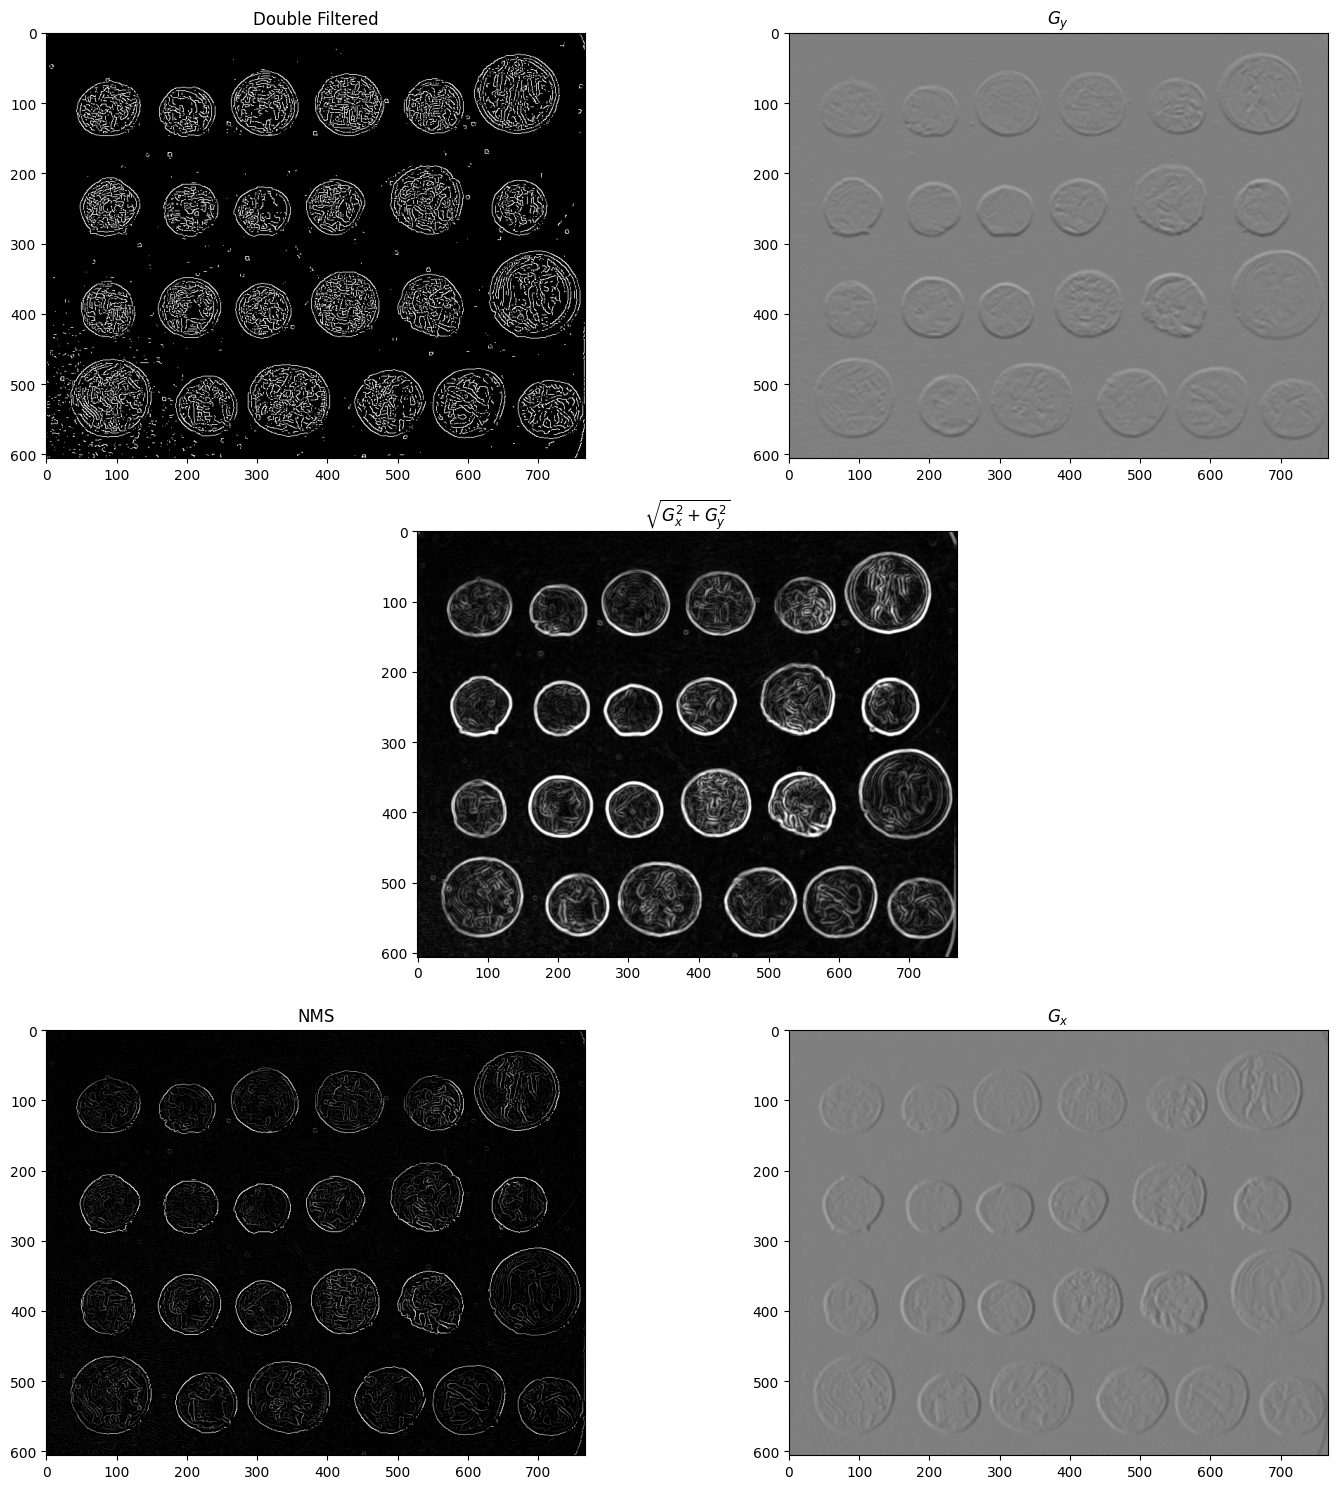

In [13]:
@interact(
    t_min=FloatSlider(min=0, max=100, value=2.5, step=.5, continuous_update=False),
    t_max=FloatSlider(min=0, max=100, value=10.0, step=.5, continuous_update=False)
)
def run(t_min, t_max):
    double_t = double_filter(nms_mag, t_min, t_max)
    plt.figure(figsize=(15,15))
    plt.subplot(326)
    plt.title("$G_x$")
    plt.imshow((((g_x / 1024.0) + 1) * 127.5), cmap='gray', vmin=0, vmax=255)
    plt.subplot(322)
    plt.title("$G_y$")
    plt.imshow((((g_y / 1024.0) + 1) * 127.5), cmap='gray', vmin=0, vmax=255)
    plt.subplot(312)
    plt.title("$\sqrt{G_x^2 + G_y^2}$")
    plt.imshow(mag, cmap='gray', vmin=0, vmax=255)
    plt.subplot(325)
    plt.title("NMS")
    plt.imshow(nms_mag, cmap='gray', vmin=0, vmax=255)
    plt.subplot(321)
    plt.title("Double Filtered")
    plt.imshow(double_t, cmap='gray', vmin=0, vmax=255)
    plt.tight_layout()